# Imports and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pymc3 as pm
from sklearn.linear_model import LinearRegression
import arviz as az
%matplotlib inline

# Data

In [2]:
sleep_data = pd.read_csv('SleepStudyData.csv')
print(sleep_data.shape)
sleep_data.tail(10)
# I am checking the tail because I have added my observations at the end of the dataset.

(114, 6)


,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
104,Yes,6.0,Yes,Yes,2,No
105,Yes,7.0,Yes,Yes,2,No
106,Yes,8.0,Yes,Yes,3,No
107,Yes,9.0,Yes,Yes,3,No
108,Yes,6.0,Yes,Yes,1,No
109,Yes,6.0,Yes,Yes,2,No
110,Yes,7.0,Yes,Yes,3,No
111,Yes,8.0,Yes,Yes,3,No
112,Yes,6.0,Yes,Yes,2,No
113,Yes,6.0,Yes,Yes,2,No


In [3]:
null_counts = sleep_data.isnull().sum()
null_counts

Enough        0
Hours         2
PhoneReach    0
PhoneTime     0
Tired         0
Breakfast     0
dtype: int64

In [4]:
# Impute the missing values with the 
missing_col = ['Hours']
for i in missing_col:
     sleep_data.loc[sleep_data.loc[:,i].isnull(),i]=sleep_data.loc[:,i].mean()

# Check Data Profile

Text(0.5, 0, 'Duration of sleep (Hours)')

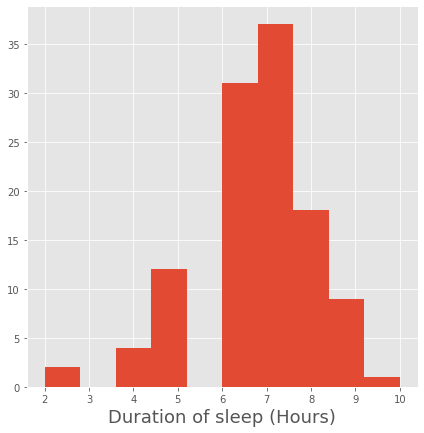

In [37]:
plt.figure(figsize=(7, 7))
plt.hist(sleep_data['Hours']);
plt.xlabel('Duration of sleep (Hours)', size = 18) 

Text(0.5, 0, 'Tiredness level(1 least, 5 most)')

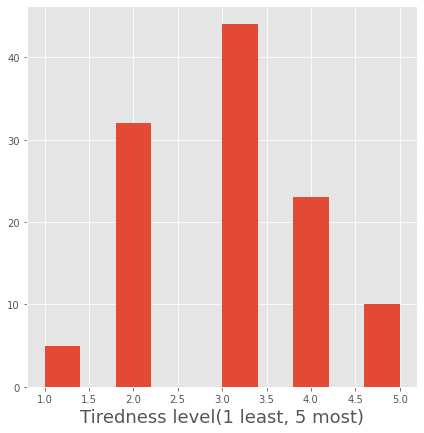

In [38]:
plt.figure(figsize=(7, 7))
plt.hist(sleep_data['Tired']);
plt.xlabel('Tiredness level(1 least, 5 most)', size = 18) 

/Users/prashantmudgal/env_1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


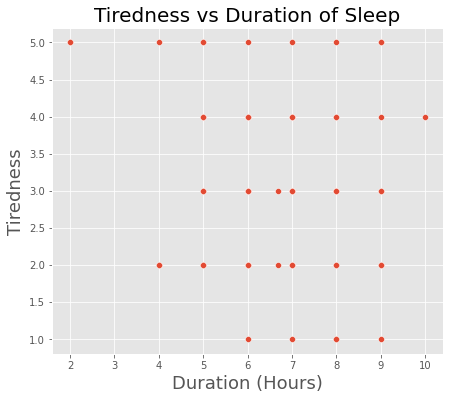

In [48]:
plt.figure(figsize = (7, 6))
sns.scatterplot(sleep_data['Hours'], sleep_data['Tired'])
plt.xlabel('Duration (Hours)', size = 18); plt.ylabel('Tiredness', size = 18); 
plt.title('Tiredness vs Duration of Sleep', size = 20);

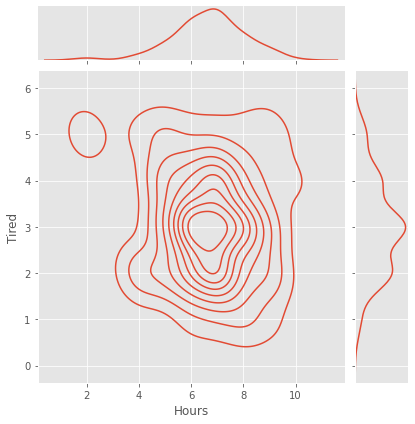

In [42]:
sns.jointplot(x = "Hours", y = "Tired", 
              kind = 'kde', data = sleep_data) 

In [9]:
sleep_data['Intercept'] = 1
sleep_data.head(2)

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast,Intercept
0,Yes,8.0,Yes,Yes,3,Yes,1
1,No,6.0,Yes,Yes,3,No,1


# Bayesian Model

In [10]:
# Create the features and response
X = sleep_data.loc[:, ['Intercept', 'Hours']]
y = sleep_data.loc[:, 'Tired']

In [11]:
with pm.Model() as bayesian_linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 5)
    
    # Slope 
    slope = pm.Normal('slope', mu = 2, sd = 0.05)
   
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    tiredness = intercept + slope * X.loc[:, 'Hours']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = tiredness, sd = sigma, observed = y.values)
    
    # Posterior distribution
    linear_trace = pm.sample(1000)

/Users/prashantmudgal/env_1/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


/Users/prashantmudgal/env_1/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


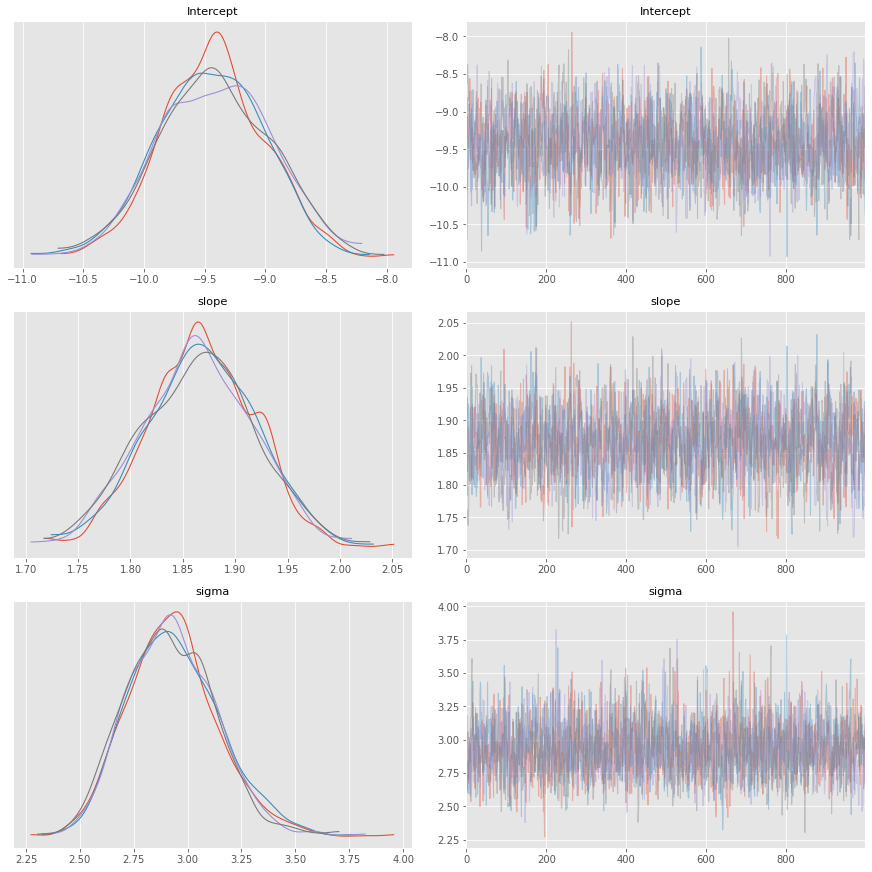

In [36]:
az.plot_trace(linear_trace, figsize=(12,12));

/Users/prashantmudgal/env_1/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


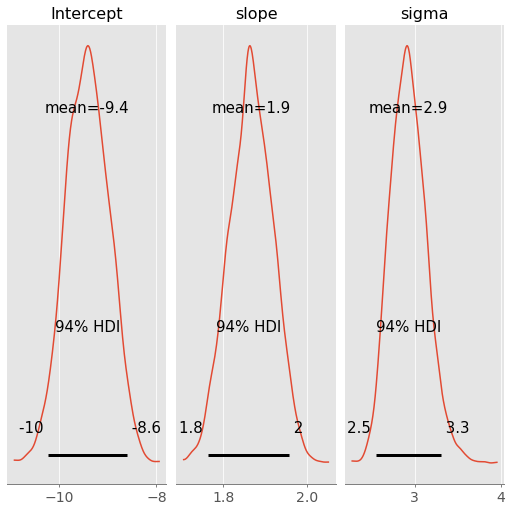

In [35]:
pm.plot_posterior(linear_trace, figsize = (7, 7));

In [20]:
bayes_prediction = linear_trace['Intercept'] + linear_trace['slope'] * 6.5

In [21]:
bayes_prediction.mean()

2.706287617697848

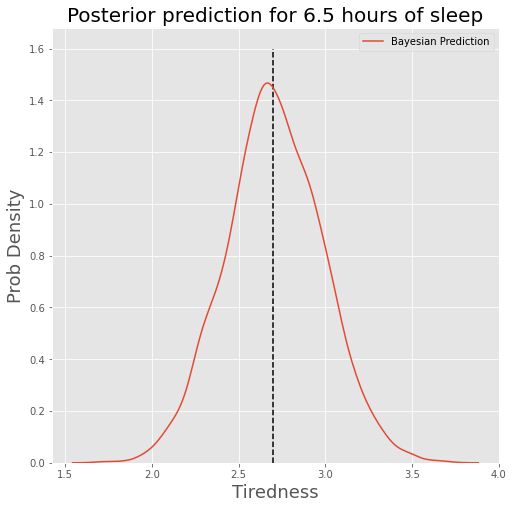

In [34]:
plt.figure(figsize = (8, 8))
plt.style.use('ggplot')
sns.kdeplot(bayes_prediction, label = 'Bayesian Prediction')
plt.vlines( bayes_prediction.mean().round(1), ymin = 0.0, ymax = 1.6, colors='black', linestyles='--')
plt.legend();
plt.xlabel('Tiredness', size = 18), plt.ylabel('Prob Density', size = 18);
plt.title('Posterior prediction for 6.5 hours of sleep', size = 20);

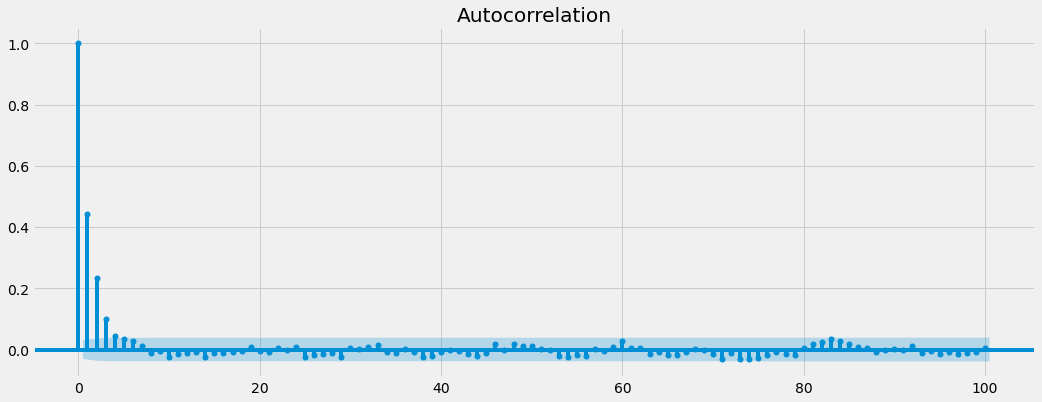

In [68]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(linear_trace['slope'], lags=100, ax=ax);

# Linear Regression

In [26]:
lr = LinearRegression()
x_t = X['Hours'].to_numpy()
lr.fit(x_t.reshape(-1, 1), y)

LinearRegression()

In [27]:
print('intercept is:', lr.intercept_)
print('slope is:', lr.coef_[0])

intercept is: 3.767397132070683
slope is: -0.11359093937375088


In [28]:
print('Sleeping for for 6.5 hours will cause tiredness index of {:.2f} .'.format(
    lr.intercept_ + lr.coef_[0] * 6.5))

Sleeping for for 6.5 hours will cause tiredness index of 3.03 .


# Latex equations